# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Muhammad Rafif Alfarizti
- Email: a200ybf339@devacademy.id
- Id Dicoding: a200ybf339

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

### Menyiapkan data yang akan diguankan

In [ ]:
# Membaca dataset
ip = pd.read_csv('data.csv', delimiter=';')
ip

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## Data Understanding

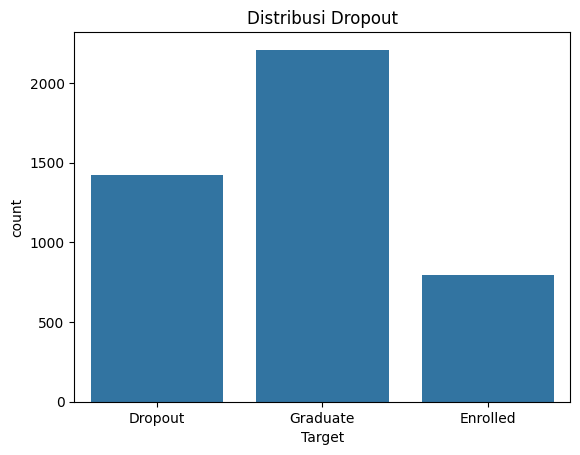

In [3]:
# Distribusi dropout (anggap kolom dropout bernama 'Target')
sns.countplot(data=ip, x='Target')
plt.title("Distribusi Dropout")
plt.show()

In [5]:
# Pisahkan kolom numerik saja (tanpa mengubah Target)
numeric_cols = ip.select_dtypes(include=['number'])

# Hitung korelasi antar kolom numerik
correlation_matrix = numeric_cols.corr()

# Cek apakah kolom 'Target' ada di original dataframe dan numerik
if 'Target' in ip.columns and pd.api.types.is_numeric_dtype(ip['Target']):
    target_corr = correlation_matrix['Target'].drop('Target')
else:
    # Hitung korelasi manual antara Target (non-numerik) dan kolom numerik
    target_corr = ip[numeric_cols.columns].apply(lambda x: ip['Target'].astype('category').cat.codes.corr(x))

# Urutkan korelasi berdasarkan kekuatan absolut
correlation_with_Target_sorted = target_corr.reindex(
    target_corr.abs().sort_values(ascending=False).index
)

# Tampilkan hasil
print("Korelasi terhadap Target (dari paling signifikan):")
print(correlation_with_Target_sorted)


Korelasi terhadap Target (dari paling signifikan):
Curricular units 2nd sem (approved)               0.624157
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.529123
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Age at enrollment                                -0.243438
Debtor                                           -0.240999
Gender                                           -0.229270
Application mode                                 -0.221747
Curricular units 2nd sem (enrolled)               0.175847
Curricular units 1st sem (enrolled)               0.155974
Admission grade                                   0.120889
Displaced                                         0.113986
Previous qualification (grade)                    0.103764
Curricular units 2nd sem (without evaluations)   -0.094028
Curri

## Korelasi terhadap Target: Interpretasi dan Insight

Berdasarkan analisis korelasi, ditemukan beberapa fitur yang memiliki hubungan kuat dengan variabel `Target` (yang merepresentasikan status dropout siswa). Korelasi positif menunjukkan kecenderungan lebih besar untuk **bertahan / tidak dropout**, sedangkan korelasi negatif mengindikasikan kecenderungan ke arah **dropout**.

### Fitur dengan Korelasi Positif Kuat terhadap Target
- `Curricular units 2nd sem (approved)`, `1st sem (approved)`, `grade`: Semakin tinggi jumlah dan nilai mata kuliah yang disetujui, makin besar kemungkinan siswa tidak dropout.
- `Tuition fees up to date`: Siswa yang membayar tepat waktu cenderung bertahan.
- `Scholarship holder`: Penerima beasiswa memiliki kemungkinan lebih besar untuk melanjutkan studi.

### Fitur dengan Korelasi Negatif Kuat terhadap Target
- `Age at enrollment`: Siswa yang lebih tua cenderung lebih tinggi risiko dropout.
- `Debtor`: Siswa dengan tunggakan pembayaran berpotensi besar dropout.
- `Gender`: Korelasi negatif kecil, bisa mengindikasikan perbedaan perilaku dropout berdasarkan gender.
- `Application mode`: Beberapa jalur masuk tertentu tampaknya memiliki risiko dropout lebih tinggi.

### Fitur Korelasi Lemah
Fitur-fitur seperti `Father's qualification`, `Father's occupation`, `International`, `Educational special needs` menunjukkan hampir **tidak ada hubungan** signifikan terhadap dropout. Artinya, mereka dapat dipertimbangkan untuk dieliminasi dalam proses seleksi fitur untuk menyederhanakan model.

## Kesimpulan
Fitur akademik dan finansial memiliki peran paling signifikan dalam memprediksi dropout siswa. Sementara itu, faktor demografis seperti pekerjaan atau pendidikan orang tua tampaknya kurang berpengaruh.


## Data Preparation / Preprocessing

In [6]:
# ========================================
# Data Cleaning
# ========================================

# 1. Cek dan hapus missing values
print("Jumlah missing values sebelum dibersihkan:")
print(ip.isnull().sum())

# Menghapus baris dengan nilai null
ip = ip.dropna()

# 2. Cek dan hapus duplikat
print("\nJumlah duplikasi sebelum dibersihkan:")
print(ip.duplicated().sum())

# Menghapus baris duplikat
ip = ip.drop_duplicates()

# Konfirmasi setelah pembersihan
print("\nJumlah missing values setelah dibersihkan:")
print(ip.isnull().sum())
print("\nJumlah duplikasi setelah dibersihkan:")
print(ip.duplicated().sum())

Jumlah missing values sebelum dibersihkan:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder   

Artinya tidak ada data yang perlu dicleaning 

In [7]:
# Fitur yang dianggap tidak relevan (korelasi sangat lemah terhadap Target)
irrelevant_cols = [
    "Father's qualification",
    "Father's occupation",
    "International",
    "Educational special needs",
    "Mother's occupation",
    "Nacionality",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

# Dataset baru dengan kolom tidak relevan didrop
ipr = ip.drop(columns=irrelevant_cols)

In [8]:
# 1. Encoding data kategorikal
categorical_cols = ipr.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    ipr[col] = le.fit_transform(ipr[col].astype(str))

In [9]:
# 2. Normalisasi/Standarisasi fitur numerik 
numerical_cols = ipr.select_dtypes(include=['int64', 'float64']).columns.tolist() 
numerical_cols = [col for col in numerical_cols if col != 'Target'] 
scaler = StandardScaler() 
ipr[numerical_cols] = scaler.fit_transform(ipr[numerical_cols]) 

In [10]:
# 3. Split data 
X = ipr.drop('Target', axis=1) 
y = ipr['Target'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [11]:
# 1. Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [12]:
# 2. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# 3. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
# 4. Support Vector Machine
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [15]:
# 5. Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

## Evaluation


Model: Logistic Regression
Confusion Matrix:
[[239  29  48]
 [ 39  40  72]
 [ 14  25 379]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       316
           1       0.43      0.26      0.33       151
           2       0.76      0.91      0.83       418

    accuracy                           0.74       885
   macro avg       0.67      0.64      0.65       885
weighted avg       0.72      0.74      0.73       885

ROC AUC Score (multiclass ovr): 0.8652633082741373

Model: Random Forest
Confusion Matrix:
[[233  35  48]
 [ 42  44  65]
 [  8  22 388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       316
           1       0.44      0.29      0.35       151
           2       0.77      0.93      0.84       418

    accuracy                           0.75       885
   macro avg       0.68      0.65      0.66       885
weighted avg    

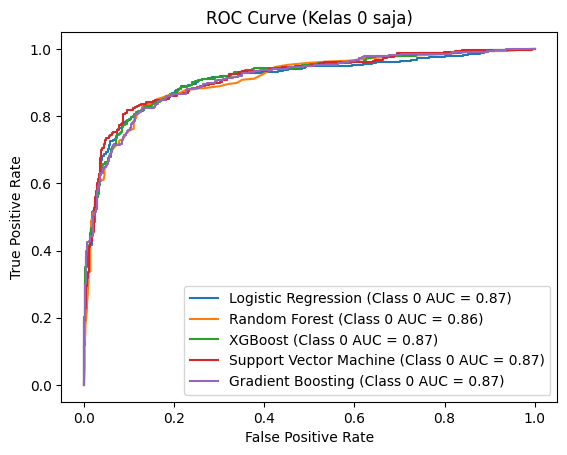

In [16]:
def evaluate_model(model, name):
    print(f"\nModel: {name}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC AUC Score untuk multiclass dengan average
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
        print("ROC AUC Score (multiclass ovr):", auc_score)

        # ROC Curve multiclass ditampilkan hanya untuk kelas pertama (opsional visualisasi)
        fpr, tpr, _ = roc_curve(y_test == 0, y_proba[:, 0])  # bisa diubah ke kelas lain
        plt.plot(fpr, tpr, label=f"{name} (Class 0 AUC = {auc_score:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Kelas 0 saja)")
        plt.legend()
    else:
        print("Model tidak mendukung predict_proba(), ROC Curve tidak ditampilkan.")

evaluate_model(log_model, "Logistic Regression")
evaluate_model(rf_model, "Random Forest")
evaluate_model(xgb_model, "XGBoost")
evaluate_model(svm_model, "Support Vector Machine")
evaluate_model(gb_model, "Gradient Boosting")
plt.show()


In [17]:
# ip.to_excel("ip.xlsx", index=False)